<a href="https://colab.research.google.com/github/ZozolNat/A-B-testirovanie/blob/main/%22%D0%94%D0%97_8_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Урок 8. Python применение статистических критериев на практике - пайплайн оценки A/B
На сайте запущен А/В тест с целью увеличить доход. В приложенном excel файле вы найдете сырые данные по результатам эксперимента – user_id, тип выборки variant_name и доход принесенный пользователем revenue.
Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру.


Решение

In [1]:
from scipy.stats import ttest_1samp
import numpy as np

import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import shapiro
from scipy import stats
from statsmodels.stats.power import TTestIndPower

In [5]:
df = pd.read_excel('/AB_Test_Results (2).xlsx')

In [7]:
df.head(20)

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.00
1,2423,control,0.00
2,9411,control,0.00
3,7311,control,0.00
4,6174,variant,0.00
5,2380,variant,0.00
6,2849,control,0.00
7,9168,control,0.00
8,6205,variant,0.00
9,7548,control,0.00


In [8]:

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [9]:

df.describe()

,USER_ID,REVENUE
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


In [10]:

df.isna().sum()

USER_ID         0
VARIANT_NAME    0
REVENUE         0
dtype: int64

In [11]:

df.VARIANT_NAME.value_counts()

variant    5016
control    4984
Name: VARIANT_NAME, dtype: int64

In [14]:
#уберем некоторые строки, чтоб посчитать, сколько типов встречается у каждого пользователя.
v = df.\
    groupby('USER_ID', as_index=False).\
    agg({'VARIANT_NAME': pd.Series.nunique})

In [15]:
v.head(20)

,USER_ID,VARIANT_NAME
0,2,1
1,3,2
2,4,1
3,5,1
4,6,1
5,9,1
6,10,2
7,11,1
8,12,1
9,13,1


In [16]:
new_df = df.drop_duplicates(subset='USER_ID')
new_df

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0
...,...,...,...
9988,428,control,0.0
9991,8864,variant,0.0
9996,502,variant,0.0
9998,7741,control,0.0


In [18]:
# Уровень значимости alpha = 0.05
alpha = 0.05

st = shapiro(new_df.REVENUE)
print('Distribution is {}normal\n'.format( {True:'not ',
False:''}[st[1] < alpha]))

Distribution is not normal



In [19]:
control = new_df.query('VARIANT_NAME == "control"')

test = new_df.query('VARIANT_NAME == "variant"')


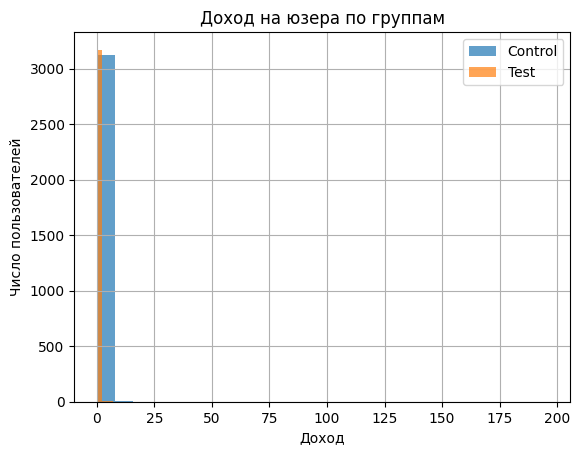

In [20]:
control.REVENUE.hist(bins = 25, alpha =0.7, label='Control')
test.REVENUE.hist(bins = 25, alpha =0.7, label='Test')
plt.title('Доход на юзера по группам')
plt.xlabel('Доход')
plt.ylabel('Число пользователей')
plt.legend();


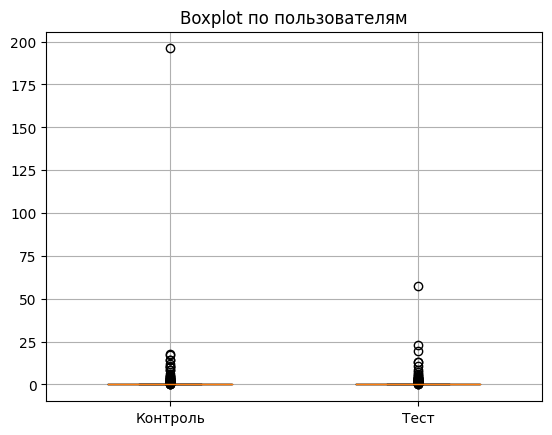

In [21]:
plt.boxplot([control.REVENUE,test.REVENUE],
            labels=['Контроль','Тест'],
            widths=0.5
           )
plt.title('Boxplot по пользователям',  loc='center')
plt.grid(axis  ='both')

In [22]:
n_control = new_df[new_df['VARIANT_NAME']=='control'].shape[0]
n_control

3132

In [23]:
n_test = new_df[new_df['VARIANT_NAME']=='variant'].shape[0]
n_test


3192

In [24]:
stats.ttest_ind(control.REVENUE.values, test.REVENUE.values, equal_var = False)

Ttest_indResult(statistic=0.8007101375053801, pvalue=0.4233485464256115)

In [25]:
C_mean = control.REVENUE.values.mean()

T_mean = test.REVENUE.values.mean()


C_std = control.REVENUE.values.std()

T_std = test.REVENUE.values.std()

In [26]:
S = np.sqrt((T_std**2 + C_std **2)/ 2)

In [28]:
effect_size =float((T_mean-C_mean)/ S)

In [29]:
analysis = TTestIndPower()
result = analysis.solve_power(effect_size=effect_size, power=None, nobs1=n_test, ratio=1.0, alpha=alpha)

result

0.1273936404253047

Т.о., результат полученный 0,127  (pvalue) > alpha. Изменения в группах не наблюдается. Также мощность теста в пределах 13%, что является низким значением. Тест следует прекратить /откатить. Можно рекомендовать собрать больше данных, внести другие изменения ил ивзять другие критерии, увеличить длительность теста, а снова запустить тест.